In [ ]:
"C:\Users\mahesh\Downloads\insurance_claims (1).csv"

In [44]:
# Auto Insurance Fraud Detection — End to End
#This notebook loads the dataset `/mnt/data/insurance_claims (1).csv`, preprocesses it, engineers features, builds a multi-node network graph (different node types), trains models (IsolationForest + RandomForest), computes risk scores, and visualizes results step-by-step.


In [45]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
import joblib
import seaborn as sns
plt.rcParams['figure.figsize'] = (10,6)
sns.set_style("whitegrid")


In [46]:
# 1) Load dataset
csv_path = r"C:\Users\mahesh\Downloads\insurance_claims (1).csv"
assert os.path.isfile(csv_path), f"CSV not found at {csv_path}"

df = pd.read_csv(csv_path)
# strip column names
df.columns = [c.strip() for c in df.columns]
print("Shape:", df.shape)
display(df.head())


Shape: (1000, 40)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [47]:
# 2) Quick inspection
print("Columns:", df.columns.tolist())
print("\nInfo:")
display(df.info())
print("\nMissing values (count):")
display(df.isna().sum().sort_values(ascending=False).head(20))


Columns: ['months_as_customer', 'age', 'policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported', '_c39']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_c

None


Missing values (count):


_c39                     1000
authorities_contacted      91
months_as_customer          0
age                         0
policy_state                0
policy_csl                  0
policy_number               0
policy_bind_date            0
policy_annual_premium       0
policy_deductable           0
insured_sex                 0
umbrella_limit              0
insured_occupation          0
insured_hobbies             0
insured_relationship        0
insured_zip                 0
capital-gains               0
capital-loss                0
incident_type               0
incident_date               0
dtype: int64

In [48]:
# 3) Preprocessing
df_clean = df.copy()

# Parse incident_date (or first date-like column)
if "incident_date" in df_clean.columns:
    df_clean["incident_date"] = pd.to_datetime(df_clean["incident_date"], errors="coerce")
else:
    date_cols = [c for c in df_clean.columns if "date" in c.lower()]
    if date_cols:
        df_clean["incident_date"] = pd.to_datetime(df_clean[date_cols[0]], errors="coerce")
    else:
        df_clean["incident_date"] = pd.NaT

# Numeric columns to coerce
numeric_cols = [
    "total_claim_amount","injury_claim","property_claim","vehicle_claim",
    "months_as_customer","age","policy_annual_premium",
    "number_of_vehicles_involved","bodily_injuries","witnesses",
    "incident_hour_of_the_day"
]
for c in numeric_cols:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce').fillna(0.0)

# Normalize fraud label (Y/N -> 1/0)
if "fraud_reported" in df_clean.columns:
    df_clean["fraud_reported"] = df_clean["fraud_reported"].astype(str).str.upper().str.strip().map({"Y":1,"N":0})
    df_clean["fraud_reported"] = df_clean["fraud_reported"].fillna(0).astype(int)

# Fill common categorical blanks
cat_fill = ["policy_state","incident_state","incident_city","auto_make","collision_type","incident_type","incident_severity","policy_number","insured_zip"]
for c in cat_fill:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].fillna("UNKNOWN").astype(str).str.strip()

# drop weird unnamed columns
drop_cols = [c for c in df_clean.columns if c.startswith("Unnamed") or c.startswith("_c")]
if drop_cols:
    df_clean = df_clean.drop(columns=drop_cols)

df_clean = df_clean.reset_index(drop=True)
print("After cleaning shape:", df_clean.shape)
display(df_clean.head())


After cleaning shape: (1000, 39)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,0


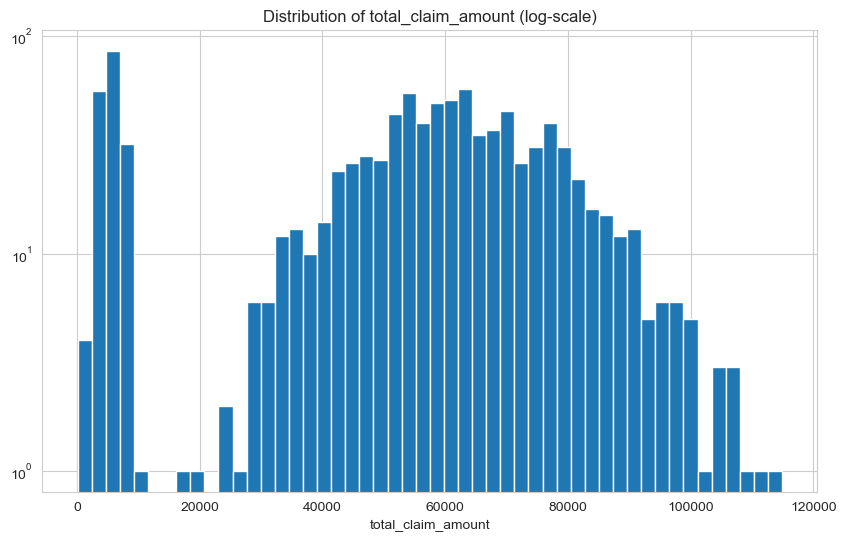

In [52]:
# 4) Exploratory visualizations
# Claim amount distribution (log scale)
if "total_claim_amount" in df_clean.columns:
    plt.figure()
    vals = df_clean["total_claim_amount"].clip(lower=0)
    plt.hist(vals, bins=50)
    plt.yscale("log")
    plt.title("Distribution of total_claim_amount (log-scale)")
    plt.xlabel("total_claim_amount")
    plt.show()




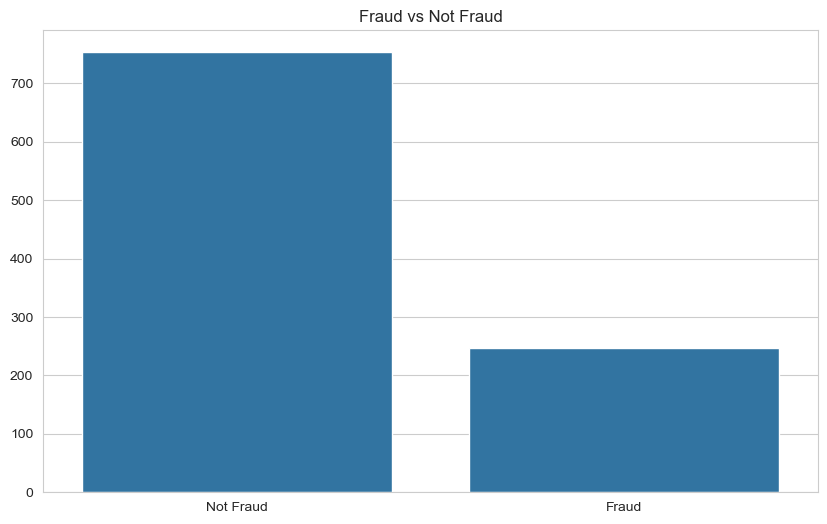

In [50]:
# Fraud counts
if "fraud_reported" in df_clean.columns:
    counts = df_clean["fraud_reported"].value_counts().sort_index()
    plt.figure()
    sns.barplot(x=["Not Fraud","Fraud"], y=counts.values)
    plt.title("Fraud vs Not Fraud")
    plt.show()

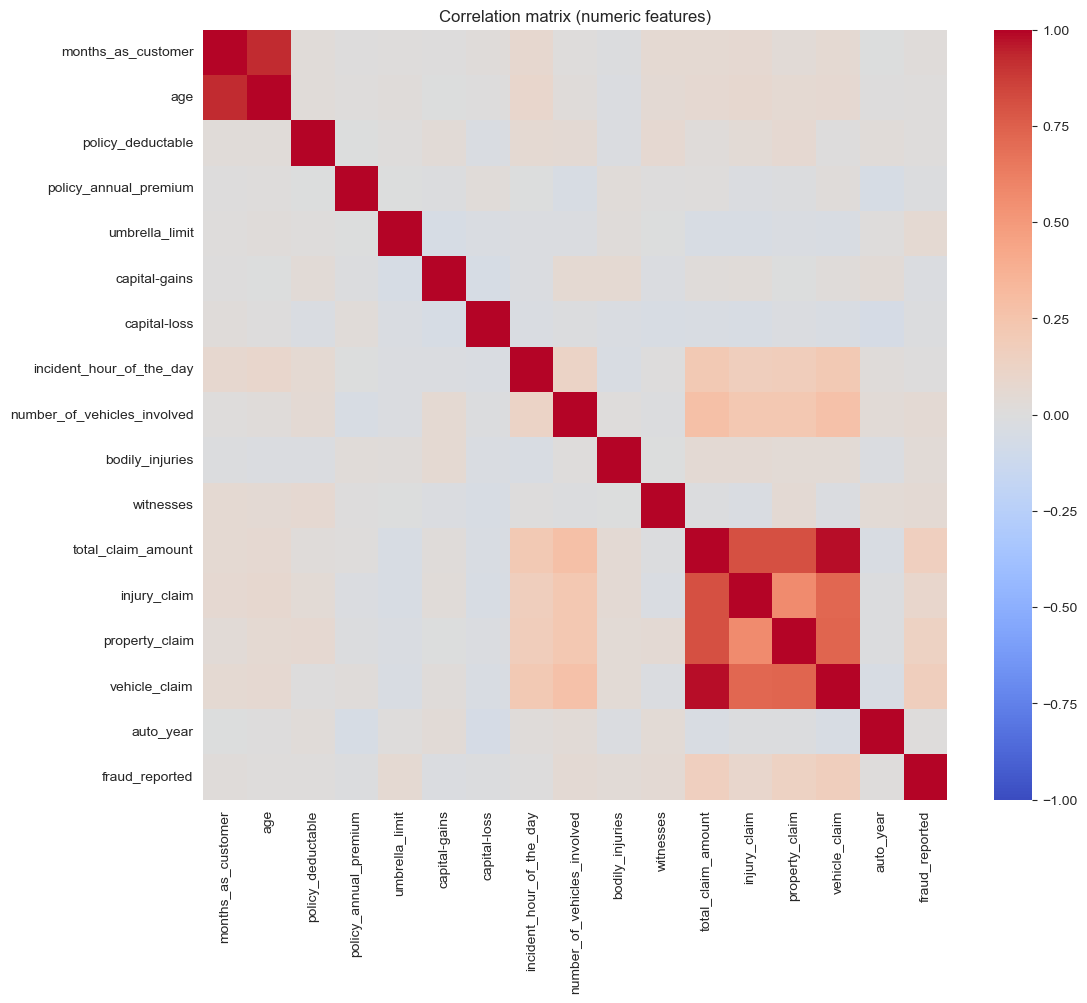

In [51]:
# Numeric correlation heatmap
num_df = df_clean.select_dtypes(include=[np.number])
if not num_df.empty:
    plt.figure(figsize=(12,10))
    sns.heatmap(num_df.corr(), annot=False, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation matrix (numeric features)")
    plt.show()

In [53]:
# 5) Feature engineering
df_fe = df_clean.copy()

# Log transform total claim amount
if "total_claim_amount" in df_fe.columns:
    df_fe["log_total_claim_amount"] = np.log1p(df_fe["total_claim_amount"].clip(lower=0))

# Ratios of claim composition
for col in ["injury_claim","property_claim","vehicle_claim"]:
    if col in df_fe.columns and "total_claim_amount" in df_fe.columns:
        denom = df_fe["total_claim_amount"].replace({0:1})
        df_fe[f"{col}_ratio"] = df_fe[col] / denom
    elif col in df_fe.columns:
        m = df_fe[col].max() if df_fe[col].max() != 0 else 1.0
        df_fe[f"{col}_ratio"] = df_fe[col] / m

# Temporal features
if "incident_date" in df_fe.columns and not df_fe["incident_date"].isna().all():
    df_fe["claim_month"] = df_fe["incident_date"].dt.month.fillna(0).astype(int)
    df_fe["claim_dayofweek"] = df_fe["incident_date"].dt.dayofweek.fillna(0).astype(int)

# One-hot encode selected categorical features (top-k)
ohe_cols = ["incident_type","collision_type","incident_severity","policy_state","incident_state","auto_make"]
ohe_features = []
for col in ohe_cols:
    if col in df_fe.columns:
        topk = df_fe[col].value_counts().nlargest(10).index
        df_fe[col] = df_fe[col].where(df_fe[col].isin(topk), "OTHER")
        dummies = pd.get_dummies(df_fe[col], prefix=col)
        df_fe = pd.concat([df_fe, dummies], axis=1)
        ohe_features += list(dummies.columns)

# Numerical features list
num_features = [
    "log_total_claim_amount","months_as_customer","age","policy_annual_premium",
    "number_of_vehicles_involved","bodily_injuries","witnesses","incident_hour_of_the_day",
    "injury_claim_ratio","property_claim_ratio","vehicle_claim_ratio","claim_month","claim_dayofweek"
]
feature_cols = [c for c in num_features if c in df_fe.columns] + ohe_features

# fallback: if no features selected, use all numeric columns except label
if not feature_cols:
    feature_cols = [c for c in df_fe.select_dtypes(include=[np.number]).columns if c != "fraud_reported"]

print("Using", len(feature_cols), "features")
display(feature_cols[:50])


Using 46 features


['log_total_claim_amount',
 'months_as_customer',
 'age',
 'policy_annual_premium',
 'number_of_vehicles_involved',
 'bodily_injuries',
 'witnesses',
 'incident_hour_of_the_day',
 'injury_claim_ratio',
 'property_claim_ratio',
 'vehicle_claim_ratio',
 'claim_month',
 'claim_dayofweek',
 'incident_type_Multi-vehicle Collision',
 'incident_type_Parked Car',
 'incident_type_Single Vehicle Collision',
 'incident_type_Vehicle Theft',
 'collision_type_?',
 'collision_type_Front Collision',
 'collision_type_Rear Collision',
 'collision_type_Side Collision',
 'incident_severity_Major Damage',
 'incident_severity_Minor Damage',
 'incident_severity_Total Loss',
 'incident_severity_Trivial Damage',
 'policy_state_IL',
 'policy_state_IN',
 'policy_state_OH',
 'incident_state_NC',
 'incident_state_NY',
 'incident_state_OH',
 'incident_state_PA',
 'incident_state_SC',
 'incident_state_VA',
 'incident_state_WV',
 'auto_make_Accura',
 'auto_make_Audi',
 'auto_make_BMW',
 'auto_make_Chevrolet',
 'auto_

In [54]:
# 6) Build multi-node graph with node types and edges similar to repo
G = nx.Graph()

# Helper to add node with type attribute
def add_node_with_type(node_id, ntype):
    if not G.has_node(node_id):
        G.add_node(node_id, ntype=ntype)

# We'll create nodes and edges per row:
# CUSTOMER node (use policy_number or insured_zip+policy_number combo)
# POLICY node (policy_number)
# CLAIM node (index-based id or a combination)
# AUTO_MAKE node (MAKE_...)
# CITY node (CITY_...)
# ZIP node (ZIP_...)
# INCIDENT_TYPE node
# COLLISION_TYPE node
# INCIDENT_SEVERITY node

for idx, r in df_fe.iterrows():
    claim_node = f"CLAIM_{idx}"
    add_node_with_type(claim_node, "claim")
    # policy
    if "policy_number" in r and r["policy_number"]:
        policy_node = f"POLICY_{r['policy_number']}"
        add_node_with_type(policy_node, "policy")
        G.add_edge(claim_node, policy_node)
        # optionally add policy->customer (customer node using insured_zip+policy or insured name if present)
        if "insured_zip" in r and r["insured_zip"]:
            cust_node = f"CUST_{r['insured_zip']}"
            add_node_with_type(cust_node, "customer")
            G.add_edge(policy_node, cust_node)
    # auto make
    if "auto_make" in r and r["auto_make"]:
        make_node = f"MAKE_{r['auto_make']}"
        add_node_with_type(make_node, "make")
        G.add_edge(claim_node, make_node)
    # city / zip
    if "incident_city" in r and r["incident_city"]:
        city_node = f"CITY_{r['incident_city']}"
        add_node_with_type(city_node, "city")
        G.add_edge(claim_node, city_node)
    if "insured_zip" in r and r["insured_zip"]:
        zip_node = f"ZIP_{r['insured_zip']}"
        add_node_with_type(zip_node, "zip")
        G.add_edge(claim_node, zip_node)
    # incident_type
    if "incident_type" in r and r["incident_type"]:
        it_node = f"INCIDENTTYPE_{r['incident_type']}"
        add_node_with_type(it_node, "incident_type")
        G.add_edge(claim_node, it_node)
    # collision_type
    if "collision_type" in r and r["collision_type"]:
        col_node = f"COLLISION_{r['collision_type']}"
        add_node_with_type(col_node, "collision_type")
        G.add_edge(claim_node, col_node)
    # severity
    if "incident_severity" in r and r["incident_severity"]:
        sev_node = f"SEV_{r['incident_severity']}"
        add_node_with_type(sev_node, "severity")
        G.add_edge(claim_node, sev_node)

print("Graph built — nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())


Graph built — nodes: 4020 edges: 8000


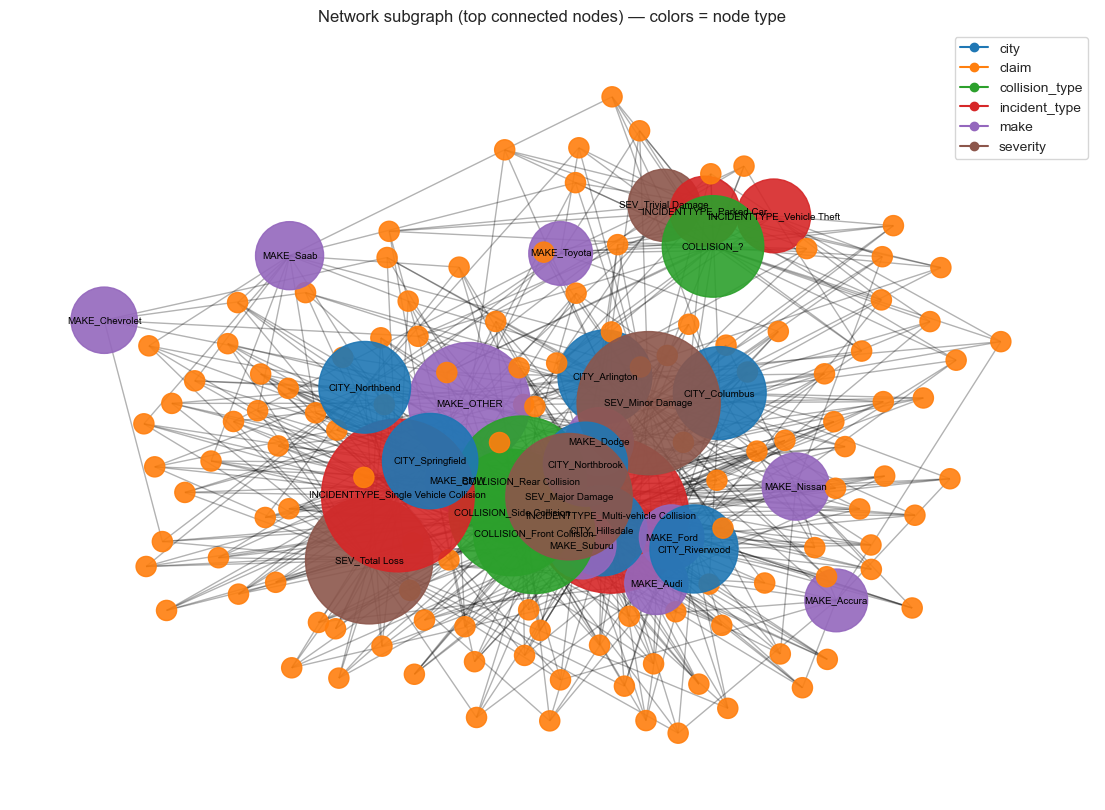

In [56]:
# 7) Visualize graph — color nodes by type and draw top subgraph to keep readable
# compute degree and select top nodes to display (avoid plotting huge graphs)
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:150]  # tune number
sub_nodes = [n for n,_ in top_nodes]
H = G.subgraph(sub_nodes).copy()

# build color map by node type
ntypes = nx.get_node_attributes(H, "ntype")
unique_types = sorted(set(ntypes.values()))
# color palette
palette = sns.color_palette("tab10", n_colors=max(10, len(unique_types)))
type2color = {t: palette[i % len(palette)] for i,t in enumerate(unique_types)}
node_colors = [type2color.get(ntypes.get(n, "unknown"), (0.6,0.6,0.6)) for n in H.nodes()]

plt.figure(figsize=(14,10))
pos = nx.spring_layout(H, seed=42, k=0.5)
# node sizes by degree
node_sizes = [max(50, degree_dict.get(n,1)*30) for n in H.nodes()]
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(H, pos, alpha=0.3)
# draw labels only for high-degree nodes
labels = {n: n if degree_dict.get(n,0) > 8 else "" for n in H.nodes()}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=7)
plt.title("Network subgraph (top connected nodes) — colors = node type")
# legend for node types
for t, col in type2color.items():
    plt.plot([], [], marker='o', color=col, label=t)
plt.legend(loc='upper right')
plt.axis("off")
plt.show()


In [57]:
# 8) Compute a network score per claim: use degree-centrality of connected nodes (simple heuristic)
deg_all = dict(G.degree())
net_score = []
for idx, r in df_fe.iterrows():
    claim_node = f"CLAIM_{idx}"
    s = 0.0
    # consider connected nodes' degree
    if G.has_node(claim_node):
        for nbr in G.neighbors(claim_node):
            s += deg_all.get(nbr,0)
    net_score.append(s)
net_score = np.array(net_score, dtype=float)
if net_score.max() == net_score.min():
    net_norm = np.zeros_like(net_score)
else:
    net_norm = (net_score - net_score.min()) / (net_score.max() - net_score.min())
df_fe["network_score"] = net_norm
print("Network score added")
display(df_fe[["network_score"]].head())


Network score added


,network_score
0,0.689989
1,0.508073
2,0.808396
3,0.665231
4,0.326157


In [58]:
# 9) Train models
X = df_fe[feature_cols].fillna(0.0)
print("X shape:", X.shape)

# IsolationForest (anomaly)
iso = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
iso.fit(X)
raw_iso = iso.decision_function(X)
anomaly_score = 1 - (raw_iso - raw_iso.min()) / (raw_iso.max() - raw_iso.min() + 1e-12)
df_fe["anomaly_score"] = anomaly_score

# RandomForest if label exists
if "fraud_reported" in df_fe.columns:
    y = df_fe["fraud_reported"].astype(int)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    proba_val = clf.predict_proba(X_val)[:,1] if hasattr(clf,'predict_proba') else None
    print("Classifier validation report:")
    print(classification_report(y_val, preds, digits=4))
    try:
        print("ROC AUC:", roc_auc_score(y_val, proba_val))
    except:
        pass
    df_fe["clf_proba"] = clf.predict_proba(X)[:,1]
else:
    clf = None
    df_fe["clf_proba"] = 0.0
    print("No fraud label found — only IsolationForest trained")


X shape: (1000, 46)
Classifier validation report:
              precision    recall  f1-score   support

           0     0.8303    0.9073    0.8671       151
           1     0.6000    0.4286    0.5000        49

    accuracy                         0.7900       200
   macro avg     0.7152    0.6679    0.6835       200
weighted avg     0.7739    0.7900    0.7772       200

ROC AUC: 0.7688876875253413


In [59]:
# 10) Compute final risk and confidence (weights can be tuned)
def normalize_arr(a):
    a = np.asarray(a, dtype=float)
    if a.max() == a.min():
        return np.zeros_like(a)
    return (a - a.min()) / (a.max() - a.min())

a_n = normalize_arr(df_fe["anomaly_score"].values)
c_n = normalize_arr(df_fe["clf_proba"].values)
n_n = normalize_arr(df_fe["network_score"].values)

weights = {"anomaly":0.45, "clf":0.45, "network":0.10}
risk = weights["anomaly"]*a_n + weights["clf"]*c_n + weights["network"]*n_n
confidence = 1 - np.abs(a_n - c_n)

df_fe["risk_score"] = risk
df_fe["confidence"] = confidence

# Build investigation queue — tie-break by total_claim_amount if exists
sort_cols = ["risk_score", "confidence"]
asc = [False, False]
if "total_claim_amount" in df_fe.columns:
    sort_cols.append("total_claim_amount")
    asc.append(False)

df_queue = df_fe.sort_values(sort_cols, ascending=asc).reset_index(drop=True)
df_queue["priority_rank"] = df_queue.index + 1

# Show top 10
display(df_queue.head(10))


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,auto_make_OTHER,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,network_score,anomaly_score,clf_proba,risk_score,confidence,priority_rank
0,115,31,569714,2005-12-04,OH,500/1000,1000,1051.67,0,479824,...,False,False,False,False,0.679225,0.876455,0.820,0.867822,0.975356,1
1,440,61,212674,1992-09-01,OH,250/500,500,1050.76,0,467942,...,False,False,False,False,0.671690,0.688134,0.880,0.811994,0.721101,2
2,375,50,120485,2007-02-18,OH,100/300,1000,1275.39,0,466283,...,False,False,False,False,0.638321,0.731059,0.840,0.808193,0.807982,3
3,453,60,149367,2003-03-18,IN,100/300,500,1298.91,6000000,459504,...,False,False,False,False,0.666308,0.716402,0.810,0.789561,0.826293,4
4,41,25,958857,1992-01-15,IN,100/300,1000,1226.83,0,607763,...,False,False,False,False,0.694295,0.606222,0.900,0.787284,0.617211,5
5,290,45,583169,1998-02-01,IL,100/300,500,1085.03,0,476303,...,False,False,False,False,0.702906,0.712606,0.800,0.786568,0.833485,6
6,186,38,536052,2006-04-21,OH,250/500,2000,1218.56,0,477373,...,False,True,False,False,0.691066,0.773748,0.740,0.783227,0.960561,7
7,478,63,852002,2009-06-29,IL,250/500,1000,1292.30,0,479724,...,False,False,False,False,0.320775,0.884721,0.705,0.778828,0.890004,8
8,421,56,728025,1990-02-15,IN,100/300,500,1935.85,4000000,470826,...,True,False,False,False,0.886975,0.574128,0.870,0.777275,0.618084,9
9,451,61,533941,1998-06-18,IN,250/500,2000,1618.65,2000000,475407,...,False,False,False,False,0.720129,0.694108,0.790,0.775021,0.825976,10


In [60]:
# 11) Save outputs and models
out_csv = "investigation_queue_full.csv"
models_dir = "models_notebook"
os.makedirs(models_dir, exist_ok=True)

df_queue.to_csv(out_csv, index=False)
joblib.dump(iso, os.path.join(models_dir, "iso.joblib"))
if clf is not None:
    joblib.dump(clf, os.path.join(models_dir, "clf.joblib"))

print("Saved:", out_csv)
print("Saved models to:", models_dir)


Saved: investigation_queue_full.csv
Saved models to: models_notebook


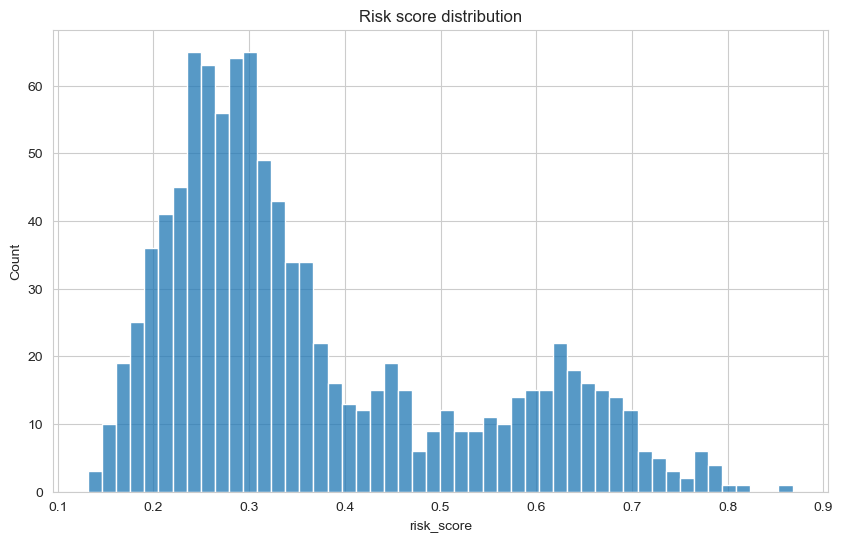

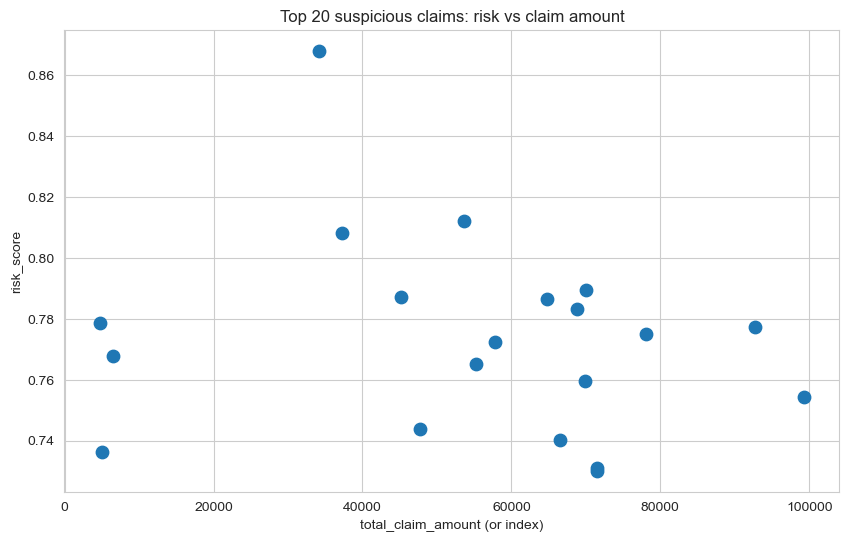

In [61]:
# 12) Visualizations of results
plt.figure()
sns.histplot(df_queue["risk_score"], bins=50, kde=False)
plt.title("Risk score distribution")
plt.show()

# Top 20 by risk_amount vs total_claim_amount (scatter)
top20 = df_queue.head(20)
plt.figure(figsize=(10,6))
plt.scatter(top20["total_claim_amount"] if "total_claim_amount" in top20.columns else range(len(top20)),
            top20["risk_score"], s=80)
plt.title("Top 20 suspicious claims: risk vs claim amount")
plt.xlabel("total_claim_amount (or index)")
plt.ylabel("risk_score")
plt.show()


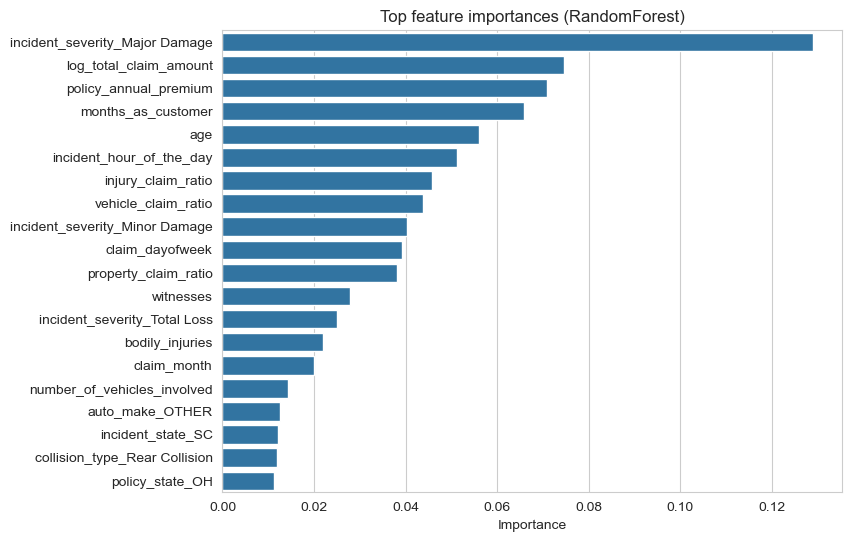

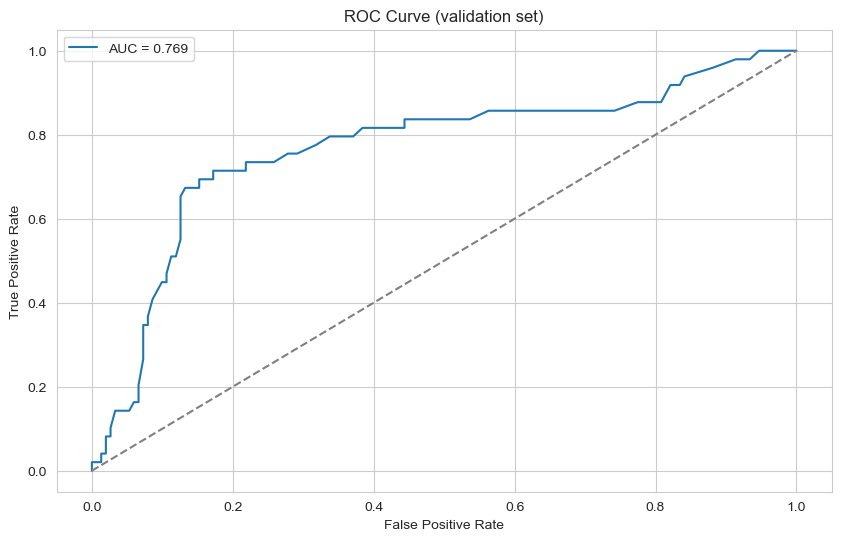

In [63]:
# 13) Feature importance (if classifier trained) and ROC
if clf is not None:
    importances = clf.feature_importances_
    idx = np.argsort(importances)[-20:][::-1]
    top_feats = [feature_cols[i] for i in idx]
    top_imps = importances[idx]

    plt.figure(figsize=(8,6))
    sns.barplot(x=top_imps, y=top_feats)
    plt.title("Top feature importances (RandomForest)")
    plt.xlabel("Importance")
    plt.show()

    # ROC on validation set
    try:
        y_val_proba = proba_val
        fpr, tpr, _ = roc_curve(y_val, proba_val)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1],[0,1], linestyle='--', color='gray')
        plt.title("ROC Curve (validation set)")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()
    except:
        pass
else:
    print("Classifier not trained — skipping feature importances and ROC.")


In [64]:
# 14) Quick manual explanation of top suspicious claim
top = df_queue.iloc[0]
print("Top suspicious claim index in original:", top.name)
display(top[ ["risk_score","confidence","total_claim_amount","anomaly_score","clf_proba","network_score"] + (["incident_type","collision_type","incident_severity"] if "incident_type" in top.index else []) ])
print("\nYou can inspect feature values for this claim to understand why it was flagged.")


Top suspicious claim index in original: 0


risk_score                           0.867822
confidence                           0.975356
total_claim_amount                      34160
anomaly_score                        0.876455
clf_proba                                0.82
network_score                        0.679225
incident_type         Multi-vehicle Collision
collision_type                 Side Collision
incident_severity                Major Damage
Name: 0, dtype: object


You can inspect feature values for this claim to understand why it was flagged.


In [65]:
# 15) Optional quick filters: show suspicious claims above threshold
threshold = 0.6
high = df_queue[df_queue["risk_score"] >= threshold]
print(f"Claims with risk >= {threshold}: {len(high)}")
display(high.head(50))


Claims with risk >= 0.6: 142


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,auto_make_OTHER,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,network_score,anomaly_score,clf_proba,risk_score,confidence,priority_rank
0,115,31,569714,2005-12-04,OH,500/1000,1000,1051.67,0,479824,...,False,False,False,False,0.679225,0.876455,0.820,0.867822,0.975356,1
1,440,61,212674,1992-09-01,OH,250/500,500,1050.76,0,467942,...,False,False,False,False,0.671690,0.688134,0.880,0.811994,0.721101,2
2,375,50,120485,2007-02-18,OH,100/300,1000,1275.39,0,466283,...,False,False,False,False,0.638321,0.731059,0.840,0.808193,0.807982,3
3,453,60,149367,2003-03-18,IN,100/300,500,1298.91,6000000,459504,...,False,False,False,False,0.666308,0.716402,0.810,0.789561,0.826293,4
4,41,25,958857,1992-01-15,IN,100/300,1000,1226.83,0,607763,...,False,False,False,False,0.694295,0.606222,0.900,0.787284,0.617211,5
5,290,45,583169,1998-02-01,IL,100/300,500,1085.03,0,476303,...,False,False,False,False,0.702906,0.712606,0.800,0.786568,0.833485,6
6,186,38,536052,2006-04-21,OH,250/500,2000,1218.56,0,477373,...,False,True,False,False,0.691066,0.773748,0.740,0.783227,0.960561,7
7,478,63,852002,2009-06-29,IL,250/500,1000,1292.30,0,479724,...,False,False,False,False,0.320775,0.884721,0.705,0.778828,0.890004,8
8,421,56,728025,1990-02-15,IN,100/300,500,1935.85,4000000,470826,...,True,False,False,False,0.886975,0.574128,0.870,0.777275,0.618084,9
9,451,61,533941,1998-06-18,IN,250/500,2000,1618.65,2000000,475407,...,False,False,False,False,0.720129,0.694108,0.790,0.775021,0.825976,10


In [66]:
# Add explicit fraud flag and auto-pay action

def decide_action(score):
    if score >= 0.60:
        return "INVESTIGATE"
    else:
        return "AUTO-PAY"

df_queue["fraud_flag"] = df_queue["risk_score"].apply(lambda x: 1 if x >= 0.60 else 0)
df_queue["action"] = df_queue["risk_score"].apply(decide_action)

display(df_queue[["risk_score", "confidence", "fraud_flag", "action"]].head(20))


,risk_score,confidence,fraud_flag,action
0,0.867822,0.975356,1,INVESTIGATE
1,0.811994,0.721101,1,INVESTIGATE
2,0.808193,0.807982,1,INVESTIGATE
3,0.789561,0.826293,1,INVESTIGATE
4,0.787284,0.617211,1,INVESTIGATE
5,0.786568,0.833485,1,INVESTIGATE
6,0.783227,0.960561,1,INVESTIGATE
7,0.778828,0.890004,1,INVESTIGATE
8,0.777275,0.618084,1,INVESTIGATE
9,0.775021,0.825976,1,INVESTIGATE
